In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import seaborn as sns
import os

In [2]:
# Load the preprocessed CSV file
file_path = os.path.join("processed_data", "preprocessed_dataset.csv")
df = pd.read_csv(file_path)

print("Shape of the dataset:", df.shape)

Shape of the dataset: (1019035, 79)


In [3]:
# Identify columns with only one unique value
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]

# Display constant columns and their unique values
for col in constant_cols:
    print(f"{col}: {df[col].unique()}")

# Drop them afterward
df.drop(columns=constant_cols, inplace=True)
print(f"\nDropped {len(constant_cols)} constant columns")

print("Shape of the dataset after drop constant columns:", df.shape)

Bwd PSH Flags: [0]
Fwd URG Flags: [0]
Bwd URG Flags: [0]
CWE Flag Count: [0]
Fwd Avg Bytes/Bulk: [0]
Fwd Avg Packets/Bulk: [0]
Fwd Avg Bulk Rate: [0]
Bwd Avg Bytes/Bulk: [0]
Bwd Avg Packets/Bulk: [0]
Bwd Avg Bulk Rate: [0]

Dropped 10 constant columns
Shape of the dataset after drop constant columns: (1019035, 69)


In [4]:
def correlated_features(df, threshold):
    # Compute correlation matrix (absolute value)
    corr_matrix = df.corr(numeric_only=True).abs()

    # Keep upper triangle only
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    correlated_groups = {}
    visited = set()

    for col in upper.columns:
        if col in visited:
            continue

        correlated_with_col = upper[col][upper[col] > threshold].index.tolist()
        # Remove already visited features from the list
        correlated_with_col = [feat for feat in correlated_with_col if feat not in visited]

        if correlated_with_col:
            correlated_groups[col] = correlated_with_col
            visited.update(correlated_with_col)
            visited.add(col)

    # Display the results
    if correlated_groups:
        print(f"\nFeatures with strong correlations (>|{threshold}|):")
        for feature, related in correlated_groups.items():
            print(f"  {feature} = {related}")
    else:
        print("No features have high correlation above the threshold.")

    return correlated_groups

In [5]:
def drop_correlated_columns(df, features_to_drop):
    df_filtered = df.drop(columns=features_to_drop, errors='ignore')

    print("Columns removed due to high correlation:")
    print(features_to_drop)

    return df_filtered

In [6]:
def top_mutual_info(df, label_col, test_size, top_k, random_state=42):
    _, sample_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df[label_col],
        random_state=42
    )

    # Check label distribution in full dataset vs. sample
    print("Label distribution in the full dataset:")
    print(df[label_col].value_counts(normalize=True))

    print("\nLabel distribution in the sampled subset:")
    print(sample_df[label_col].value_counts(normalize=True))

    # Separate features and label
    X = sample_df.drop(columns=[label_col])  
    y = sample_df[label_col] 

    # Compute mutual information between features and label
    mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'MI Score': mi_scores
    }).sort_values(by='MI Score', ascending=False).reset_index(drop=True)

    # Select top k features
    top_features = mi_df.head(top_k)

    # Plot MI Scores
    plt.figure(figsize=(10, len(top_features) * 0.2))
    sns.barplot(
        x='MI Score',
        y='Feature',
        data=top_features,
        palette='viridis'
    )

    plt.title(f'Top {top_k} Features by Mutual Information', fontsize=14)
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return top_features

Label distribution in the full dataset:
Label
0    0.615632
2    0.169620
1    0.125625
3    0.089123
Name: proportion, dtype: float64

Label distribution in the sampled subset:
Label
0    0.6157
2    0.1696
1    0.1256
3    0.0891
Name: proportion, dtype: float64


C:\Users\Khanh Quynh\AppData\Local\Temp\ipykernel_4736\825259123.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


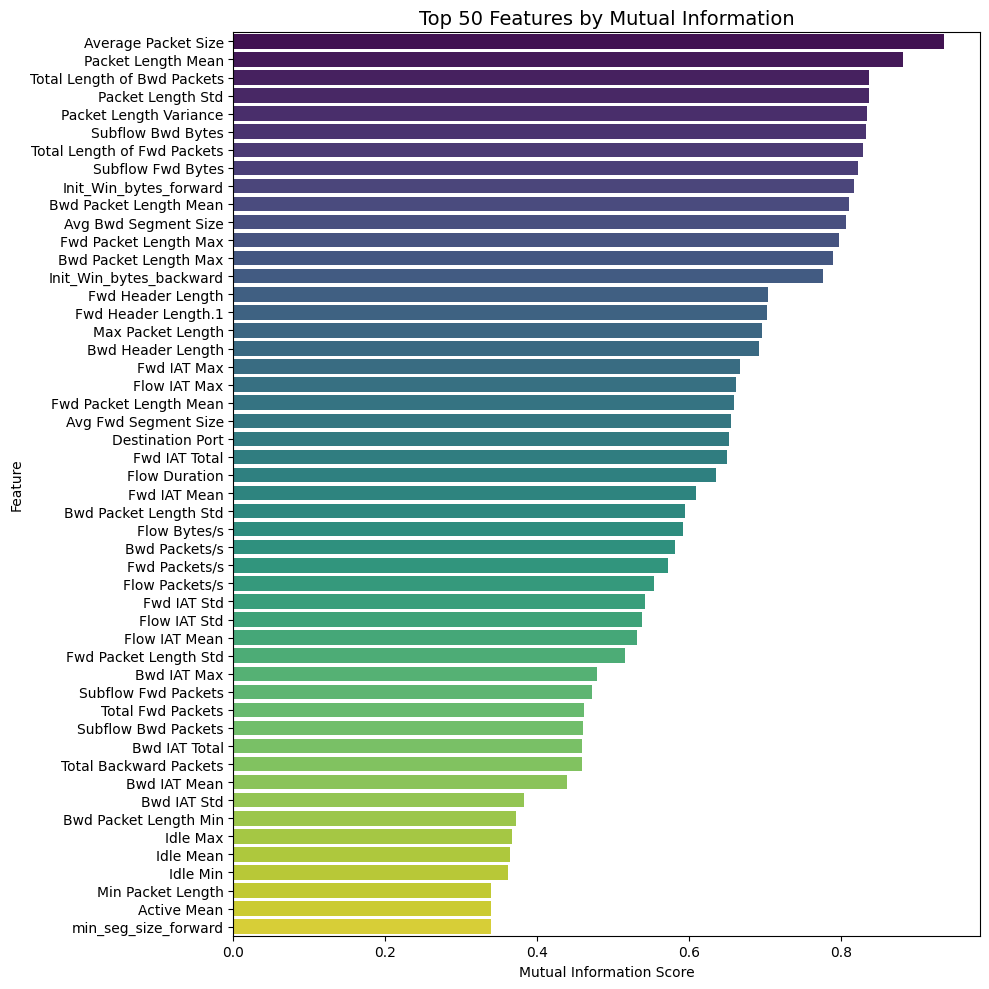

In [7]:
# Find top 50 features have the highest MI scores
top_features = top_mutual_info(df, 'Label', 10000, 50)

In [8]:
# Save new DataFrame that contains only top 50 features
selected_columns = top_features['Feature'].tolist()
selected_df = df[selected_columns + ['Label']]

In [9]:
# Check the shape after saving DataFrame
selected_df.shape

(1019035, 51)

In [10]:
# Check highly correlated features
correlated_groups = correlated_features(selected_df, 0.95)


Features with strong correlations (>|0.95|):
  Packet Length Mean = ['Average Packet Size']
  Subflow Bwd Bytes = ['Total Length of Bwd Packets']
  Subflow Fwd Bytes = ['Total Length of Fwd Packets']
  Avg Bwd Segment Size = ['Bwd Packet Length Mean']
  Fwd Header Length.1 = ['Fwd Header Length']
  Max Packet Length = ['Packet Length Std']
  Flow IAT Max = ['Fwd IAT Max']
  Avg Fwd Segment Size = ['Fwd Packet Length Mean']
  Flow Duration = ['Fwd IAT Total']
  Bwd Packet Length Std = ['Bwd Packet Length Max']
  Flow Packets/s = ['Fwd Packets/s']
  Fwd Packet Length Std = ['Fwd Packet Length Max']
  Subflow Fwd Packets = ['Bwd Header Length']
  Subflow Bwd Packets = ['Total Fwd Packets']
  Idle Max = ['Fwd IAT Std', 'Flow IAT Std']
  Idle Min = ['Idle Mean']


In [11]:
# Select highly correlated features to remove
features_to_drop = [
    'Packet Length Mean', 'Subflow Bwd Bytes', 'Subflow Fwd Bytes'
    'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Packet Length Std',
    'Fwd IAT Max', ' Avg Fwd Segment Size', 'Fwd IAT Total', 
    'Bwd Packet Length Std', 'Fwd Packets/s', 'Fwd Packet Length Std',
    'Bwd Header Length', 'Total Fwd Packets', 'Fwd IAT Std', 
    'Flow IAT Std', 'Idle Mean'
]

selected_df = drop_correlated_columns(selected_df, features_to_drop)

Columns removed due to high correlation:
['Packet Length Mean', 'Subflow Bwd Bytes', 'Subflow Fwd BytesAvg Bwd Segment Size', 'Fwd Header Length.1', 'Packet Length Std', 'Fwd IAT Max', ' Avg Fwd Segment Size', 'Fwd IAT Total', 'Bwd Packet Length Std', 'Fwd Packets/s', 'Fwd Packet Length Std', 'Bwd Header Length', 'Total Fwd Packets', 'Fwd IAT Std', 'Flow IAT Std', 'Idle Mean']


In [12]:
# Check the shape after removing highly correlated features
selected_df.shape

(1019035, 37)

In [13]:
# Check remaining features
selected_df.columns

Index(['Average Packet Size', 'Total Length of Bwd Packets',
       'Packet Length Variance', 'Total Length of Fwd Packets',
       'Subflow Fwd Bytes', 'Init_Win_bytes_forward', 'Bwd Packet Length Mean',
       'Avg Bwd Segment Size', 'Fwd Packet Length Max',
       'Bwd Packet Length Max', 'Init_Win_bytes_backward', 'Fwd Header Length',
       'Max Packet Length', 'Flow IAT Max', 'Fwd Packet Length Mean',
       'Avg Fwd Segment Size', 'Destination Port', 'Flow Duration',
       'Fwd IAT Mean', 'Flow Bytes/s', 'Bwd Packets/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Bwd IAT Max', 'Subflow Fwd Packets',
       'Subflow Bwd Packets', 'Bwd IAT Total', 'Total Backward Packets',
       'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Min', 'Idle Max',
       'Idle Min', 'Min Packet Length', 'Active Mean', 'min_seg_size_forward',
       'Label'],
      dtype='object')

In [14]:
# Save the DataFrame to a CSV file
selected_df.to_csv("processed_data/feature_selection_dataset.csv", index=False)
print("Data saved to feature_selection_dataset.csv")

Data saved to feature_selection_dataset.csv
